# What's in an election?

I started collecting datasets about the 2020 US elections about a week before voting day, and as these things usually go, I forgot to stop.
In fact, I kept collecting data for almost three whole months.
That mountain of data turned out to be beneficial, however.
Instead of collecting a dataset about a US election, we collected a dataset about US elections, US politics, US laws and US disobedience.

That sounds noisy, but it isn't.
The dataset is a very broad overview of US politics teeming with change, and thus affords us a glimpse into how different algorithms handle dynamic event domains.

First, we load the necessary libraries and set a general stylesheet.

In [1]:
import importlib
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import re

sys.path.append(os.path.expanduser("~/GitHub/multiplex-plot"))
sys.path = list(set(sys.path))

from multiplex import drawable
plt.style.use(os.path.join(os.getcwd(), '../modern-custom.style'))

data = os.path.expanduser('~/DATA/c4-ate/elections/analyses/verified')

## Familiar patterns no more

Remember how TF-ICF and TF-DCF out-performed Rank Difference and Domain Specificity in football and Formula 1?
The first group extracted many general terms, and the second was too specific and captured many named entities.

**Conclusion:** In the election dataset, the trends in results of football matches and Formula 1 grands prix are reversed.

The specific methods, especially Rank Difference, outperform every other method.
TF-ICF and TF-DCF are again too general, capturing terms like _vote_, _elect_, _peopl_ and _support_.
Conversely, Domain Specificity and Rank Difference pick out terms that are highly specific to the domain of US politics.

In [2]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@k', 'terms' ])

analysis = 'results-new-ap'
files = os.listdir(os.path.join(data, analysis)) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(data, analysis, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        p_k = sorted([ (int(k), precision) for k, precision in results['results']['p@k'].items() ],
                     key=lambda _pk: _pk[0])
        p_k = [ precision for _, precision in p_k ]
        terms = results['pcmd']['terms']
        
        # insert it all in the dataframe
        df.loc[len(df)] = { 'method': method,
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'recall': summary['recall'], 'f1': summary['f1'], 'p@k': p_k,
                            'terms': terms }

df = df.sort_values(by=['ap'], ascending=False)
df = df.set_index('method', drop=True)
df

,precision,recall,f1,ap,p@k,terms
method,,,,,,
rank,0.350,0.059778,0.102115,0.029413,"[1, 1.0, 0.6666666666666666, 0.75, 0.8, 0.6666...","[administr, president-elect, inaugur, pardon, ..."
rank-50,0.355,0.060632,0.103574,0.028170,"[1, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333...","[president-elect, inaugur, pardon, presidenti,..."
tf-idf,0.320,0.054654,0.093363,0.024698,"[1, 1.0, 1.0, 0.75, 0.8, 0.6666666666666666, 0...","[elect, vote, president-elect, say, administr,..."
tf-dcf,0.305,0.052092,0.088986,0.022982,"[1, 1.0, 1.0, 0.75, 0.6, 0.6666666666666666, 0...","[elect, president-elect, vote, trump, say, pre..."
specificity,0.280,0.047822,0.081692,0.013755,"[0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0...","[inaugur, pro-trump, incit, runoff, recount, o..."
ef-idf-entropy,0.260,0.044406,0.075857,0.012163,"[0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.3333...","[conced, pardon, fump, donald, recount, hunter..."


A look at the top 30 terms in each ranking shows the difference between the rankings.
Rank Difference performs remarkably well, identifying many words that are immediately linked with US politics.
Domain Specificity is somewhat worse, but even it is far better than TF-ICF's and TF-DCF's terms.

EF-ICF-Entropy is somewhere in-between, slightly better than most methods, but lagging far behind Rank Difference, at least in terms of Average Precision.
One of the biggest reasons behind EF-ICF-Entropy's poor performance relative to Rank Difference is similar to the challenge it faced in Formula 1: it cannot exploit POS tagging information.
As a result, EF-ICF-Entropy's ranking is filled with named entities—many persons related to US politics, but also important locations.

In [3]:
names = { 'specificity-nva': 'Domain Specificity', 'specificity': 'Domain Specificity',
          'rank-50': 'Rank Difference',
          'tf-idf': 'TF-ICF', 'tf-dcf': 'TF-DCF',
          'tf-idf-nva': 'TF-ICF', 'tfdcf-nva': 'TF-DCF',
          'ef-idf-entropy': 'EVATE' }

for method in df.index:
    if method in names:
        print(f"\033[1m{ names.get(method, method) }\033[0m")
        print(df.loc[method].terms[:30])
        print()

Rank Difference
['president-elect', 'inaugur', 'pardon', 'presidenti', 'transit', 'elector', 'democraci', 'ralli', 'lawsuit', 'overturn', 'impeach', 'secretari', 'lawyer', 'climat', 'biden', 'protest', 'senat', 'certifi', 'advis', 'immigr', 'conced', 'violenc', 'alli', 'pro-trump', 'recount', 'veto', 'coup', 'riot', 'admin', 'lawmak']

TF-ICF
['elect', 'vote', 'president-elect', 'say', 'administr', 'trump', 'presid', 'campaign', "'re", 'support', 'inaugur', 'win', 'state', 'peopl', 'pardon', 'call', 'voter', 'said', 'year', 'get', 'result', 'presidenti', 'offic', 'offici', 'day', 'plan', 'elector', 'claim', 'take', 'polit']

TF-DCF
['elect', 'president-elect', 'vote', 'trump', 'say', 'presid', 'inaugur', 'administr', 'peopl', 'support', 'state', 'campaign', 'get', 'win', 'call', 'year', 'pardon', 'said', 'day', 'voter', 'time', 'presidenti', 'offici', 'offic', 'make', 'think', 'take', 'result', 'new', 'plan']

Domain Specificity
['inaugur', 'pro-trump', 'incit', 'runoff', 'recount', 'o

**Conclusion:** EF-ICF-Entropy captures many named entities, including prominent persons and imoprtant locations.
In just the top 30 terms, it identifies references to Donald Trump and his wife, Joe Biden and his wife, Kamala Harris, and other prominent personalities, like Rudy Giuliani.

## Making terms out of states

Apart from these names, EF-ICF-Entropy assigns a prominent ranking to the states that determined the winner of the 2021 US election: Georgia and Pennsylvania.
There's an argument for states to be considered to be terms; they are pertinent to US elections and to US politics in general.

The next cell shows how EF-ICF-Entropy greatly reduces the distance Rank Difference, unlike other algorithms.
This is a reasonable and expected outcome; the other metrics focus on nouns, verbs and adjectives, which impedes them from identifying states.
But that is also EF-ICF-Entropy's strength.

**Conclusion:** Apart from remarkable improvements in Average Precision, EF-ICF-Entropy is also the best-performing approach based on the F-measure.

When Rank Difference, the best-performing metric on the US politics dataset, considers all words, not just nouns, verbs and adjectives, it captures many names, like EF-ICF-Entropy.
At the same time, it identifies many more noisy words, like _ever_ or _alreadi_.
EF-ICF-Entropy considers all words, but filters out noise systematically.

**Conclusion:** EF-ICF-Entropy considers all terms, but is capable of filtering out noise far more than other approaches, making it more flexible.

In [4]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@k', 'terms' ])

analysis = 'results-states-new-ap'
files = os.listdir(os.path.join(data, analysis)) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(data, analysis, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        p_k = sorted([ (int(k), precision) for k, precision in results['results']['p@k'].items() ],
                     key=lambda _pk: _pk[0])
        p_k = [ precision for _, precision in p_k ]
        terms = results['pcmd']['terms']
        
        # insert it all in the dataframe
        df.loc[len(df)] = { 'method': method,
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'recall': summary['recall'], 'f1': summary['f1'], 'p@k': p_k,
                            'terms': terms }

df = df.sort_values(by=['ap'], ascending=False)
df = df.set_index('method', drop=True)
df

,precision,recall,f1,ap,p@k,terms
method,,,,,,
rank,0.350,0.057803,0.099220,0.028442,"[1, 1.0, 0.6666666666666666, 0.75, 0.8, 0.6666...","[administr, president-elect, inaugur, pardon, ..."
rank-50,0.355,0.058629,0.100638,0.027240,"[1, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333...","[president-elect, inaugur, pardon, presidenti,..."
tf-idf,0.320,0.052849,0.090716,0.023882,"[1, 1.0, 1.0, 0.75, 0.8, 0.6666666666666666, 0...","[elect, vote, president-elect, say, administr,..."
tf-dcf,0.305,0.050372,0.086464,0.022223,"[1, 1.0, 1.0, 0.75, 0.6, 0.6666666666666666, 0...","[elect, president-elect, vote, trump, say, pre..."
ef-idf-entropy,0.310,0.051197,0.087881,0.017139,"[0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.3333...","[conced, pardon, fump, donald, recount, hunter..."
specificity,0.280,0.046243,0.079376,0.013301,"[0, 0.0, 0.0, 0.0, 0.2, 0.16666666666666666, 0...","[inaugur, pro-trump, incit, runoff, recount, o..."


## What's wrong with the terms?

There is something else that separates TF-ICF and TF-DCF from Rank Difference, Domain Specificity and EF-ICF-Entropy: what they get wrong.
The next analysis evaluates each approach based on how many common terms they capture.
For this experiment, we used EF's list of the 1000 most common terms in the English language.

**Conclusion:** More than three-quarters of TF-ICF's and TF-DCF's terms are common terms, well ahead of the rest.
Rank Difference and Domain Specificity rein in the number of common terms by what they value most in terms: the fact that they are uncommon in general.
Conversely, EF-ICF-Entropy is averse to common terms because they are rarely topical.

In [5]:
# create the dataframe
df = pd.DataFrame(columns=[ 'method', 'precision', 'recall', 'f1', 'ap', 'p@k', 'terms', 'gold' ])

analysis = 'results-common-new-ap'
files = os.listdir(os.path.join(data, analysis)) # the evaluation files
pattern = re.compile("([a-z0-9\-]+).json") # the extraction pattern (to get the number of events used to extract terms)

# load the data from the files in the directory
for file in files:
    with open(os.path.join(data, analysis, file)) as f:
        results = json.loads(f.readline())
        method = pattern.findall(file)[0]
        
        # get the summary results
        summary = results['results']['summary']
        p_k = sorted([ (int(k), precision) for k, precision in results['results']['p@k'].items() ],
                     key=lambda _pk: _pk[0])
        p_k = [ precision for _, precision in p_k ]
        terms = results['pcmd']['terms']
        gold = results['pcmd']['gold']

        # insert it all in the dataframe
        df.loc[len(df)] = { 'method': method,
                            'ap': summary['average precision'], 'precision': summary['precision'],
                            'recall': summary['recall'], 'f1': summary['f1'], 'p@k': p_k,
                            'terms': terms, 'gold': gold }

df = df.sort_values(by=['ap'], ascending=False)
df = df.set_index('method', drop=True)
df

,precision,recall,f1,ap,p@k,terms,gold
method,,,,,,,
tf-idf,0.745,0.153926,0.255137,0.113234,"[1, 1.0, 0.6666666666666666, 0.75, 0.8, 0.6666...","[elect, vote, president-elect, say, administr,...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."
tf-dcf,0.725,0.149793,0.248288,0.110555,"[1, 0.5, 0.6666666666666666, 0.5, 0.6, 0.66666...","[elect, president-elect, vote, trump, say, pre...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."
rank,0.185,0.038223,0.063356,0.010173,"[1, 0.5, 0.3333333333333333, 0.25, 0.2, 0.1666...","[administr, president-elect, inaugur, pardon, ...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."
ef-idf-entropy,0.225,0.046488,0.077055,0.008678,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[conced, pardon, fump, donald, recount, hunter...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."
rank-50,0.065,0.013430,0.022260,0.001084,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[president-elect, inaugur, pardon, presidenti,...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."
specificity,0.040,0.008264,0.013699,0.000342,"[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[inaugur, pro-trump, incit, runoff, recount, o...","{'a': 'a', 'abil': 'ability', 'abl': 'able', '..."


More than just inconvenient, common words can mislead machines.
They tell our systems that common words have a significance in the domain when they obviously don't.
Some can be dangerous: the word _thought_ isn't just a general term, but it signals subjectivity, which can be harmful for areas that look for objectivity instead of opinions, like summarization.

> Note: Some terms are also common words, like _vote_ and _elect_, but many others aren't.

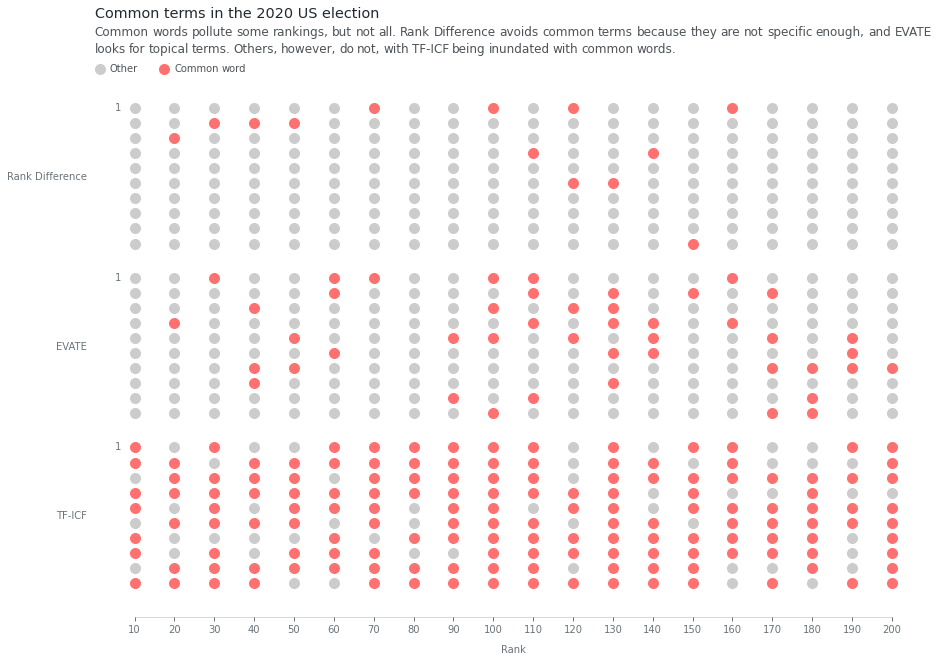

In [6]:
# create the styles
style = { 's': 100, 'color': 'C5', 'label': 'Other' }
common = dict(style)
common.update({ 'color': 'C2', 'label': 'Common word' })

# prepare the data
methods = ( 'rank-50', 'ef-idf-entropy', 'tf-idf' )
populations = { }
for method in methods:
    populations[method] = [ common if term in df.loc[method].gold else style
                                   for term in df.loc[method].terms ]

# draw the visualization
viz = drawable.Drawable(plt.figure(figsize=(15, 10)))
for method in methods:
    viz.draw_population(populations[method], 10, names.get(method, method), height=0.8, show_start=True)

# finalize the plot
viz.set_xlabel('Rank')
viz.set_title('Common terms in the 2020 US election', loc='left')
viz.set_caption(f"""Common words pollute some rankings, but not all.
                    Rank Difference avoids common terms because they are not specific enough, and EVATE looks for topical terms.
                    Others, however, do not, with TF-ICF being inundated with common words.""",
                align='justify')
viz.savefig('../exports/4.4-common-words.png', dpi=300, bbox_inches='tight')

The question follows naturally: what, then, do EF-ICF-Entropy, Rank Difference and Domain Specificity get wrong if not common terms?
Aside from some named entities, which are more prevalent in EF-ICF-Entropy, many other terms fall somewhere in the middle, between technical political and legal terms, and common words:

1. Like in the Formula 1 datasets, each time period has its own specific vocabulary.
   News about COVID-19 dominated the newswire late in 2020, and reflected in the rankings.
   Health emergencies are hardly political, but they are still linked with politics.
   
   Other news items fade in and out of relevance.
   Reports of a scandal involving Joe Biden's son, Hunter Biden, and his laptop fooled these algorithms into mistaking _laptop_ for a domain term.

2. Many other words aren't so ephemeral, with tight links to politics without being political.
   For instance, Joe Biden promised a _stimulus_ package if he was elected president, but that's an economic term.
   The word _climate_ (in the sense of _climate change_) is environmental, but it's also a political topic.
   Other words are more common, like _journalist_.

**Conclusion:** EF-ICF-Entropy performs more consistently than the other approaches.
The specificity-based methods, Rank Difference and Doman Specificity, perform abysmally in football and Formula 1.
The more general methods, TF-ICF and TF-DCF, perform better in those domains, but falter in broader domains.

Only EF-ICF-Entropy performs more consistently, with a blip in the Formula 1 datasets, where the sample is not sufficiently broad.
Even in the domain of US politics, the difference in average precision between Rank Difference and EF-ICF-Entropy is very misleading, as the next notebook shows.